# Fourier Shell Correlation with Gold Beads in Widefield mode

Widefield (non-confocal) microscopes are generally not very well suited for 3D imaging as the absence of the optical pinhole allows all the out-of-focus light to overlap with the in-focus details on every focal position. Deconvolution-based techniques, have been proposed to address this issue -- with mixed results. Also in lightsheet microscopy widefield detection is used; the recorded fluorescence signal is restricted to the detection objectives focal plane by the planar light-sheet illumintaion. 

In any case on simple samples, with only limited out-of-focus light, it should be possible to estimate the 3D FSC also in widefield images. Here we characterize how the method works on simple sub-resolution nanoparticle samples. 

In [128]:
%matplotlib inline
from ipywidgets import interact, fixed
from scipy import ndimage

import numpy as np

import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
from supertomo.analysis.resolution.fourier_shell_correlation import DirectionalFSC
from supertomo.data.containers.image import Image
import supertomo.data.iterators.fourier_shell_iterators as iterators
import supertomo.analysis.resolution.analysis as fsc_analysis



def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Test Data

A pair of 3D stacks were recorded in line-by-line fashion with our custom laser scanning microscope -- the fluorescence signal was recorded with the non-descanned fluorescence detector, thus emulating a regular widefield detection scheme. Sample of 80nm gold nanoparticles was used to avoid effects of photobleaching.

The images were recorded with isotropic 80nmx80nmx80nm pixel size. Because the image thickness is much smaller than the height/width zero padding is applied here to match image dimensions. Typically the axial dimension is sampled less densely than the lateral, due to different Nyquist frequencies. In such case, resampling would be applied here as well. 

In [129]:
# Image
data_dir = "/Users/sami/OneDrive - Fondazione Istituto Italiano Tecnologia/Microscopy/2018_04_FSC_measures_confocal"
image_name = "2018_04_23_80nm_Gold_ndd.tif"

# Get script options
args_list = [data_dir, '--bin-delta=8', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=snr', '--resolution-snr-value=0.5',
            '--angle-delta=30','--extract-angle-delta=0.5',
             '--resolution-point-sigma=0.001', '--use-splines']
args = options.get_frc_script_options(args_list)

# Get image
image1 = read.get_image(os.path.join(data_dir, image_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image_name), channel=1)

#image1 = Image(np.transpose(image1, (0,2,1)), image1.spacing)
#image2 = Image(np.transpose(image2, (0,2,1)), image2.spacing)

# Pre-process
#image = imops.zoom_to_isotropic_spacing(image, order=0)
image1 = imops.zero_pad_to_cube(image1)
image2 = imops.zero_pad_to_cube(image2)

interact(show_axial_slice, image1=fixed(image1), image2=fixed(image2), slice=(0, image1.shape[0]-1))

interactive(children=(IntSlider(value=43, description=u'slice', max=86), Output()), _dom_classes=('widget-interact',))

<function __main__.show_axial_slice>

## Registration

To ensure optimal results the two 3D stacks are registered before FSC analysis. 

Setting up registration job
Starting registration
Final metric value: -0.990589857873
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 13 iterations. Current step (0.000465183) is less than minimum step (0.0005).


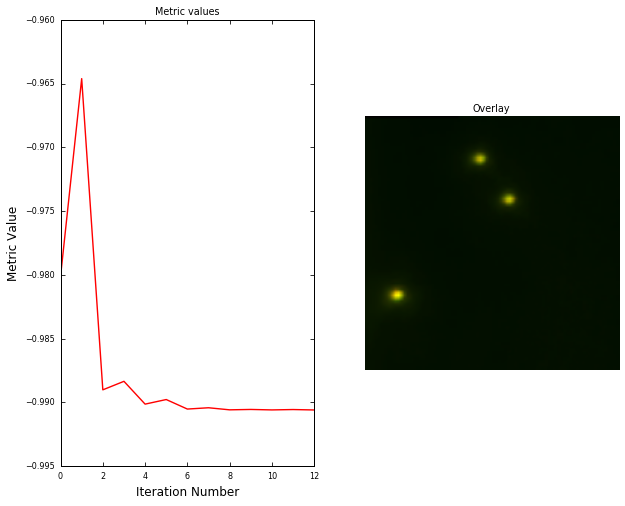

In [130]:
import SimpleITK as sitk

import supertomo.ui.supertomo_options as supertomo_options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(image1)
moving_image = itk.convert_to_itk_image(image2)


args_list_2 = ("--sampling-percentage=.01 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation " 
        "--reg-enable-observers").split()

registration_options = supertomo_options.get_debug_script_options(args_list_2)

transform = registration.itk_registration_rigid_3d(fixed_image, moving_image, registration_options)

moving_image = itk.resample_image(moving_image, transform)

image1 = itk.convert_from_itk_image(fixed_image)
image2 = itk.convert_from_itk_image(moving_image)



## Pre-smoothing

The FSC does not seem to work reliably with the raw data. This is probably due to the noisiness of the FFTs due to the very low signal level -- and the presence of out-of focus artefacts. I addressed this issue by applying anisotropic gaussian blurring.

In [ ]:
import scipy.ndimage as improc

image1 = Image(improc.gaussian_filter(image1, (2,1,1)), image1.spacing)
image2 = Image(improc.gaussian_filter(image2, (2,1,1)), image1.spacing)

In [ ]:

iterator = iterators.AxialExcludeHollowConicalFourierShellIterator(image1.shape, args.d_bin, args.d_angle, args.d_extract_angle)

fsc_task = DirectionalFSC(image1, image2, iterator)
data = fsc_task.execute()

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)

result = analyzer.execute()





## Results

The result with the pre-smoothed images look very reasonable. The numerical resolution values are reasonable, slightly less than with the confocal dataset. The radar plot show that the resolution in the axial-to-lateral resolution scale is approximately 1:3. Interestingly the axial resolution does not improve as quickly as with the confocal dataset.

In [ ]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()



In [ ]:
plotter.plot_all()